In [2]:
import Heston
import BlackScholes
import ImpliedDrift

import QuantLib as ql
import pandas as pd
import numpy as np
import copy

import datetime
import matplotlib.pyplot as plt
from matplotlib import cm

import time

In [3]:
# Read the dataset

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()

# Fix the calendar and the date for calculation

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
calculation_date = ql.Date(23, 1, 2023)
ql.Settings.instance().evaluationDate = calculation_date

# Define spot and strikes

spot = 4019.81
strikes = moneyness*spot/100
data = np.array(IV_df.drop(columns = 'Exp Date'))/100.

# Calculate the expiration dates and the Implied Drift

expiration_dates = list()
risk_free_rate = list()

for j in range(len(maturities)):
    expiration_dates.append(ql.Date(23, 1, 2023) + ql.Period(int(np.round(maturities[j]*365)), ql.Days))
    risk_free_rate.append(float(ImpliedDrift.drift(maturities[j])))

    
# Add the last point at 100 years for the Implied Drift

risk_free_rate.append(float(ImpliedDrift.drift(10)))
dates = expiration_dates.copy()
dates.append(ql.Date(23, 1, 2123))

# Define the helper for the term structure of the drift

yield_ts = ql.YieldTermStructureHandle(
    ql.ForwardCurve(dates, risk_free_rate, day_count))

# Since we have incapsulated the drift in the first term we put here dividend rate = 0 (QuantLib need this to run) 

dividend_rate = 0.0
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

N_tenors = len(expiration_dates)
N_strikes = len(strikes)

# Starting eta, kappa, theta, rho, sigma_0

params = (0.02,0.2,0.5,0.1,0.01)

In [4]:
# Define the model object and the helpers

model, engine = Heston.setup_model(
    yield_ts, dividend_ts, spot, params)

heston_helpers, grid_data = Heston.setup_helpers(
    engine, expiration_dates, strikes, data, 
    calculation_date, spot, yield_ts, dividend_ts, calendar)

initial_condition = list(model.params())

In [5]:
%%time

# Calibrate the model using Levenberg-Marquardt

lm = ql.LevenbergMarquardt(1e-15, 1e-15, 1e-15)
model.calibrate(heston_helpers, lm, ql.EndCriteria(2000, 500, 1e-15,1e-15, 1e-15))

eta, kappa, theta, rho, sigma_0 = model.params()

print (f"eta = {eta: .4f}, kappa = {kappa: .4f}, theta = {theta: .4f}, rho = {rho: .4f}, sigma_0 = {sigma_0: .4f}")
print(f"Feller condition: {2*kappa*eta-theta**2: .4f}")

eta =  0.0568, kappa =  2.6523, theta =  1.3231, rho = -0.6766, sigma_0 =  0.0442
Feller condition: -1.4494
CPU times: total: 4.2 s
Wall time: 4.2 s


In [6]:
# Calculate the prices with the calibrated model and the corresponding IV

cal_IV = np.zeros((N_tenors, N_strikes))
cal_p = np.zeros((N_tenors, N_strikes))
options_type = np.ones(N_strikes)

for j in range(N_tenors):
    cal_p[j,:] = Heston.analytic_hest(spot, strikes, maturities[j], risk_free_rate[j], 0, 
                                      kappa, theta, rho, eta, sigma_0, options_type)
    cal_IV[j,:] = BlackScholes.BSImpliedVol(spot, strikes, maturities[j], risk_free_rate[j], 0,
                                            cal_p[j,:], Option_type = 1, toll = 1e-5)

print(f"Relative mean error on IV: {np.mean(abs(data-cal_IV)/data)*100:.4f}%")

Relative mean error on IV: 4.5817%


<IPython.core.display.Javascript object>


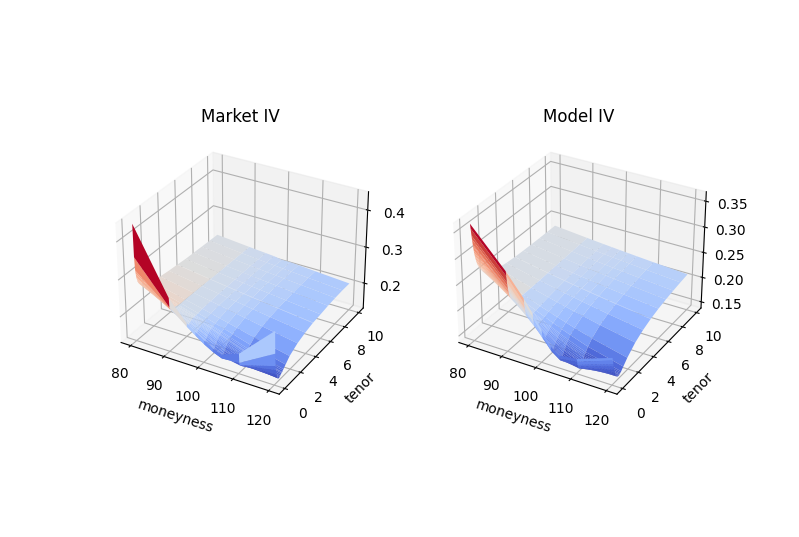

In [10]:
%matplotlib notebook

mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, data, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('moneyness')
ax1.set_ylabel('tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, cal_IV, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('moneyness')
ax2.set_ylabel('tenor')
ax2.set_title('Model IV')
plt.show()